## Using energy prediction models on simulated surfaces

In [2]:
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#### Load energy prediction model for hollow site and on-top site

In [3]:
hollow_site_model = xgb.Booster({'nthread': 4})
hollow_site_model.load_model("../models/"+"Hollow_site.model")

on_top_site_model = xgb.Booster({'nthread': 4})
on_top_site_model.load_model("../models/"+"on_top_site.model")

In [4]:
# Make a 100x100x3 surface with an even distribution of the five metals
def simulate_surface(dim_x, dim_y): #Is still random - could be used with a seed in the name of reproduceability
    #dim_x, dim_y, dim_z = 100, 100, 3 #Specify dimensions
    dim_z = 3
    surface_list = np.array([int(dim_x*dim_y*dim_z/len(metals))*[metals[metal_number]] for metal_number in range(len(metals))]).flatten() #Jack had a way shorter way of doing this, but I think it was random drawing instead of ensuring a perfectly even split
    np.random.shuffle(surface_list) #Shuffle list
    surface = np.reshape(surface_list, (dim_x, dim_y, dim_z)) #Reshape list to the
    return surface

def on_top_site_vector(surface, site_x, site_y):
    
    site1 = [surface[site_x, site_y, 0]]# Make a one-hot encoded vector of the very site here! Add at the beginning
    site1_count = [site1.count(metals[n]) for n in range(len(metals))]
    
    top6 = [surface[site_x % 100, (site_y-1) % 100, 0], surface[site_x % 100, (site_y+1) % 100, 0], surface[(site_x-1) % 100, site_y % 100, 0], surface[(site_x+1) % 100, site_y % 100, 0], surface[(site_x-1) % 100, (site_y+1) % 100, 0], surface[(site_x+1) % 100, (site_y-1) % 100, 0]]
    top6_count = [top6.count(metals[n]) for n in range(len(metals))]
    
    mid3 = [surface[(site_x-1) % 100, (site_y-1) % 100,1], surface[site_x % 100, (site_y-1) % 100,1], surface[(site_x-1) % 100, site_y % 100,1]]
    mid3_count = [mid3.count(metals[n]) for n in range(len(metals))]
    
    bot3 = [surface[(site_x-1) % 100, (site_y-1) % 100, 2], surface[(site_x-1) % 100, (site_y+1) % 100, 2], surface[(site_x+1) % 100, (site_y-1) % 100, 2]]
    bot3_count = [bot3.count(metals[n]) for n in range(len(metals))]
    
    return site1_count + top6_count + mid3_count + bot3_count

metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
three_metals_combinations = [] #List of possible combinations of the three
# Der skal være 35, ikke 125

for a in metals:
    for b in metals:
        for c in metals:
            three_metals_combinations.append(''.join(sorted([a, b, c])))
            
# Remove duplicates
three_metals_combinations = list(dict.fromkeys(three_metals_combinations)) # Let's encode it in a better way later

def hollow_site_vector(surface, site_x, site_y, adsorbate): #Now with adsorbate encoding
    
    if adsorbate == "H":
        ads = [0]
    elif adsorbate == "O":
        ads = [1]
    
    # First encode the 3 neighbours
    blues = [surface[(site_x+1) % 100, site_y, 0], surface[site_x, (site_y+1) % 100, 0], surface[(site_x+1) % 100, (site_y+1) % 100, 0]]
    blues = "".join(sorted(blues))
    idx = three_metals_combinations.index(blues)
    blues = 35*[0]
    blues[idx] = 1
    
    # Then the next neighbours (green)
    greens = [surface[(site_x+2) % 100, site_y, 0], surface[site_x, (site_y+2) % 100, 0], surface[site_x, site_y, 0]]
    greens_count = [greens.count(metals[n]) for n in range(len(metals))]
    
    # Then the next neighbours (brown) # Kunne gøres smartere med list comprehension og to lister med +- zipped
    browns = [surface[(site_x + a) % 100, (site_y + b) % 100, c] for a, b, c in zip([1, 2, 2, 1, -1, -1], [2, 1, -1, -1, 1, 2], [0, 0, 0, 0, 0, 0])]
    browns_count = [browns.count(metals[n]) for n in range(len(metals))]
    
    # Then the three downstairs neighbours
    yellows = [surface[(site_x + a) % 100, (site_y + b) % 100, c] for a, b, c in zip([0, 1, 0], [0, 0, 1], [1, 1, 1])]
    yellows_count = [yellows.count(metals[n]) for n in range(len(metals))]
    
    # Then the purples downstairs
    purples = [surface[(site_x + a) % 100, (site_y + b) % 100, c] for a, b, c in zip([1, -1, 1], [-1, 1, 1], [1, 1, 1])]
    purples_count = [purples.count(metals[n]) for n in range(len(metals))]
    
    return ads + blues + greens_count + browns_count + yellows_count + purples_count

def pandas_to_DMatrix(df):
    label = pd.DataFrame(np.random.randint(2, size=len(df)))
    DMatrix = xgb.DMatrix(df, label=label)
    return DMatrix

def pandas_to_DMatrix(df):#, label):
    label = pd.DataFrame(np.random.randint(2, size=len(df)))
    DMatrix = xgb.DMatrix(df)#, label=label)
    return DMatrix


### Create surface

The five metals used are (in alphabetical order): Ag, Au, Cu, Pd, Pt. A 100x100 surface in three layers with an even metal-distribution is created in a simple NumPy array. 

In [79]:
dim_x, dim_y = 1000, 1000
surface = simulate_surface(dim_x, dim_y)

## Predict energies of all surface sites

I will use the combined H and O model for **hollow sites** model for all hollow sites and the OH model for **on-top** sites

In [80]:
t1 = time.time()
# Find all sites in x,y
sites_list = []
for site_x in range(dim_x): #Looping through all on top sites
    for site_y in range(dim_y):
        sites_list.append([site_x, site_y])

# Make all feature vectors for all on-top and hollow sites
all_on_top_OH_df = pd.DataFrame([on_top_site_vector(surface, site_x, site_y) for site_x, site_y in sites_list], columns = [f"feature{n}" for n in range(20)])
all_hollow_H_df  = pd.DataFrame([hollow_site_vector(surface, site_x, site_y, adsorbate = "H") for site_x, site_y in sites_list], columns = [f"feature{n}" for n in range(56)])
all_hollow_O_df  = pd.DataFrame([hollow_site_vector(surface, site_x, site_y, adsorbate = "O") for site_x, site_y in sites_list], columns = [f"feature{n}" for n in range(56)])
# I forgot to add 0 for H and 1 for O in front of the vector
all_on_top_OH_DM = pandas_to_DMatrix(all_on_top_OH_df)#, label = [f"feature{n}" for n in range(20)])
all_hollow_H_DM  = pandas_to_DMatrix(all_hollow_H_df)#, label = [f"feature{n}" for n in range(55)])
all_hollow_O_DM  = pandas_to_DMatrix(all_hollow_O_df)#, label = [f"feature{n}" for n in range(55)])

## Predict energies of all sites
OH_Energies = on_top_site_model.predict(all_on_top_OH_DM)
H_Energies = hollow_site_model.predict(all_hollow_H_DM)
O_Energies = hollow_site_model.predict(all_hollow_O_DM)
All_Energies = np.concatenate((OH_Energies, H_Energies, O_Energies))
print(f"I predicted the energy of every adsorbate on every feasible site on a {dim_x}x{dim_y} surface, resulting in {dim_x*dim_y*3} energies. It took {time.time() - t1:.2f} seconds")


I predicted the energy of every adsorbate on every feasible site on a 1000x1000 surface, resulting in 3000000 energies. It took 47.97 seconds


## Plot all energies from the adsorbates

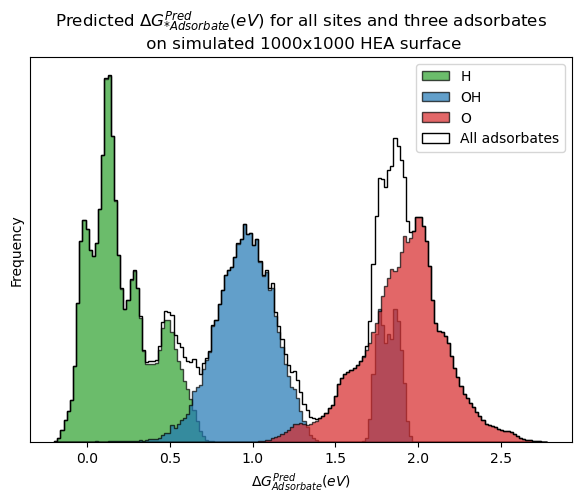

In [81]:
# Initiate plot
fig, ax = plt.subplots(1, 1, figsize = (7, 5))

# Plot histograms
ax.hist(H_Energies , bins=np.arange(-0.2, 2.8, 0.019), ec = "black", color = "tab:green", histtype = "stepfilled", density=False, alpha=0.7,label = "H")
ax.hist(OH_Energies, bins=np.arange(-0.2, 2.8, 0.019), ec = "black", color = "tab:blue" , histtype = "stepfilled", density=False, alpha=0.7,label = "OH")
ax.hist(O_Energies , bins=np.arange(-0.2, 2.8, 0.019), ec = "black", color = "tab:red"  , histtype = "stepfilled", density=False, alpha=0.7,label = "O")

ax.hist(All_Energies , bins=np.arange(-0.2, 2.8, 0.019), ec = "black", color = "tab:red"  , histtype = "step", density=False, alpha=1.0,label = "All adsorbates")
# Maybe do a sum that is transparent, but has stepfill

ax.legend()

ax.set_title("Predicted $\Delta G_{*Adsorbate}^{Pred} (eV)$ for all sites and three adsorbates\n on simulated 1000x1000 HEA surface")
ax.set_xlabel("$\Delta G_{Adsorbate}^{Pred} (eV)$")
ax.set_ylabel("Frequency")

ax.tick_params(axis='y', which='major', left=False, labelleft=False)

# Make text at each peak to show the reaction happening
if False:
    ax.text(x, y, "$H^{}$")

#plt.savefig("../figures/phase_diagram_1000_comb.png", dpi = 300, bbox_inches = "tight")
fig.show()

# Overvej at sætte tekst oveni hvert adsorbats energier


## Treat the phase diagram to arrive at CYCLIC VOLTAMMOGRAMS

Use the MAE or standard deviation on the predictions on the delta G's in the KDE's. Maybe varying this will yield different CV's. Fiddle with this to see what works best. I could also make a million billion points from a hyge surface.

In [173]:
slopes = {"H": 1, "OH": -1, "O": -2}
all_energies = {"H": H_Energies, "OH": OH_Energies, "O": O_Energies}
adsorbates = ["H", "OH", "O"]

# Number of slope PD's
sum_diff_pd = np.zeros(1000) #I have no idea why I set it to 10.000 initially. It seems excessive

for adsorbate in adsorbates:
    slope = slopes[adsorbate]
    energies = all_energies[adsorbate]
    
    for single_energy in tqdm(energies):

        V_cut = single_energy# / elementary_charge # Find the V, where the energy hits 0 # Maybe the elementary charge shouldn't be there unless the delta G's are also corrected. They arent truly at just around 0 to 3. Maybe they should be in electron volts. Ask Jack about the units:)
        V_list = np.linspace(-0.25, 2.9, 1000)
        if adsorbate == "H":
            diff_PD = [slopes[adsorbate] if V < V_cut else 0 for V in V_list]
        if adsorbate == "OH" or adsorbate == "O":
            diff_PD = [slopes[adsorbate] if V > V_cut else 0 for V in V_list]
        sum_diff_pd += diff_PD
        

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [85]:
sum_diff_pd_1000 = np.copy(sum_diff_pd)

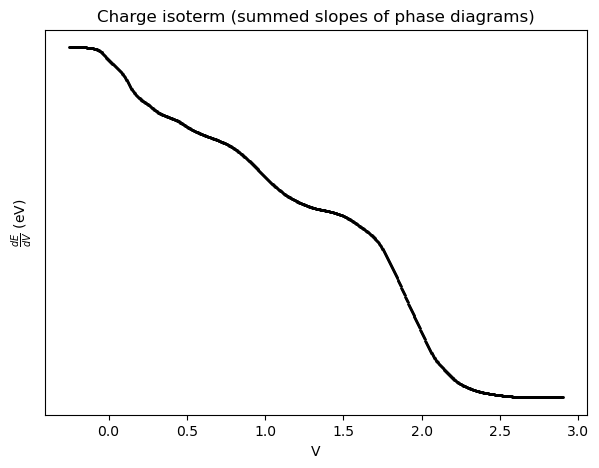

In [174]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
ax.set_title("Charge isoterm (summed slopes of phase diagrams)")
ax.scatter(V_list, sum_diff_pd, c = "black", s = 1)
ax.set_ylabel(r"$\frac{dE}{dV}$ (eV)")
ax.set_xlabel("V")
ax.set_yticks([])
#fig.savefig("../figures/CV/Charge_isoterm.png", dpi = 300, bbox_inches = "tight")
fig.show()

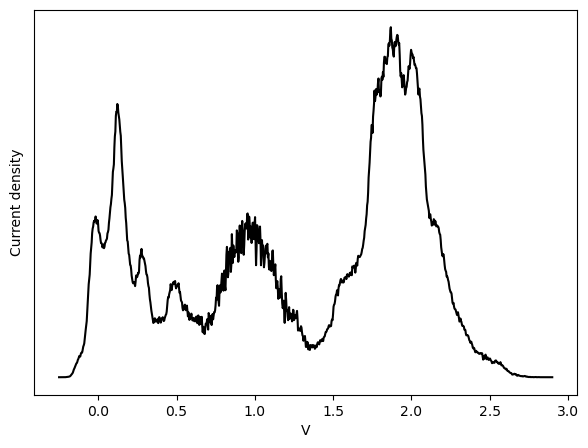

In [175]:
diff_sum_diff_pd = -np.gradient(sum_diff_pd)

fig, ax = plt.subplots(1, 1, figsize = (7, 5))

ax.plot(V_list, diff_sum_diff_pd, c = "black") #, s = 5
ax.set_yticks([])
ax.set_ylabel("Current density")
ax.set_xlabel("V")

#fig.savefig("../figures/CV/CV_raw.png", dpi = 300, bbox_inches = "tight")
fig.show()

# I think I have to run this through a spline to get a clean line

### I will try a simple moving average to remove the noise

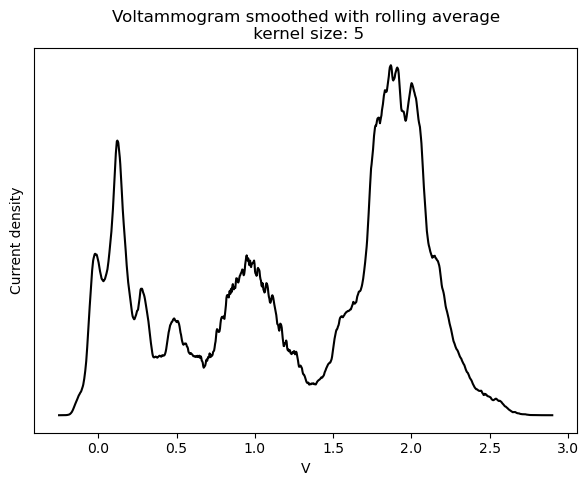

In [200]:
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
movavg_CV = np.convolve(diff_sum_diff_pd, kernel, mode='same')

fig, ax = plt.subplots(1, 1, figsize = (7, 5))
ax.set_title(f"Voltammogram smoothed with rolling average\n kernel size: {kernel_size}")
ax.plot(V_list, movavg_CV, c = "black") #, s = 5
ax.set_yticks([])
ax.set_ylabel("Current density")
ax.set_xlabel("V")

#fig.savefig("../figures/CV/CV_raw.png", dpi = 300, bbox_inches = "tight")
fig.show()

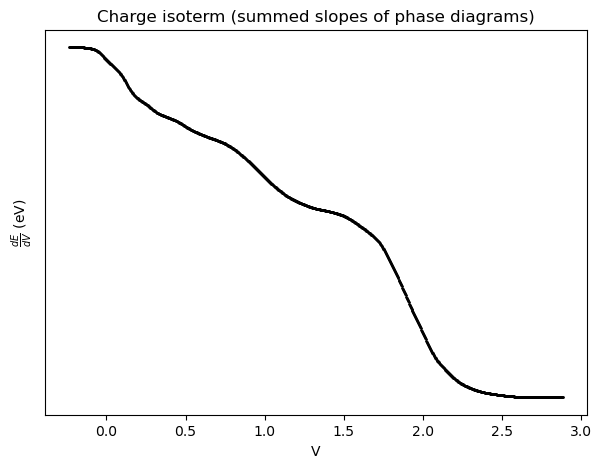

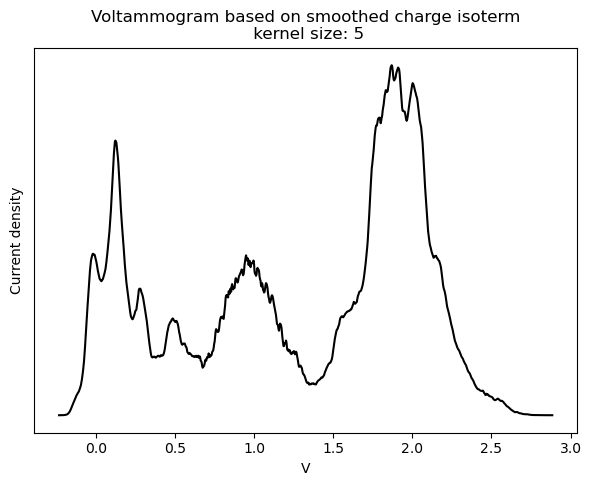

In [204]:
### What if I smooth the charge isoterm slightly instead?

# Smooth the charge isoterm slightly
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
movavg_charge_isoterm = np.convolve(sum_diff_pd, kernel, mode='same')

# Plot the smoothed charge isoterm
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
ax.set_title("Charge isoterm (summed slopes of phase diagrams)")
ax.scatter(V_list[kernel_size:-kernel_size], movavg_charge_isoterm[kernel_size:-kernel_size], c = "black", s = 1)
ax.set_ylabel(r"$\frac{dE}{dV}$ (eV)")
ax.set_xlabel("V")
ax.set_yticks([])
#fig.savefig("../figures/CV/Charge_isoterm.png", dpi = 300, bbox_inches = "tight")
fig.show()

# Make the CV
CV = -np.gradient(movavg_charge_isoterm)

fig, ax = plt.subplots(1, 1, figsize = (7, 5))
ax.set_title(f"Voltammogram based on smoothed charge isoterm\n kernel size: {kernel_size}")
ax.plot(V_list[kernel_size:-kernel_size], CV[kernel_size:-kernel_size], c = "black") #, s = 5
ax.set_yticks([])
ax.set_ylabel("Current density")
ax.set_xlabel("V")

#fig.savefig("../figures/CV/CV_raw.png", dpi = 300, bbox_inches = "tight")
fig.show()

### Functions for making CV from sum of phase diagram slopes and plot charge isoterm + Voltammogram



In [45]:
# Surface to energies #prob the hardest one
def surface_to_energies(surface, on_top_site_model, hollow_site_model):
    t1 = time.time()
    dim_x, dim_y = np.shape(surface)[0], np.shape(surface)[1]
    # Find all sites in x,y
    sites_list = []
    for site_x in range(dim_x): #Looping through all on top sites
        for site_y in range(dim_y):
            sites_list.append([site_x, site_y])
    
    # Make all feature vectors for all on-top and hollow sites
    all_on_top_OH_df = pd.DataFrame([on_top_site_vector(surface, site_x, site_y) for site_x, site_y in sites_list], columns = [f"feature{n}" for n in range(20)])
    all_hollow_H_df  = pd.DataFrame([hollow_site_vector(surface, site_x, site_y, adsorbate = "H") for site_x, site_y in sites_list], columns = [f"feature{n}" for n in range(56)])
    all_hollow_O_df  = pd.DataFrame([hollow_site_vector(surface, site_x, site_y, adsorbate = "O") for site_x, site_y in sites_list], columns = [f"feature{n}" for n in range(56)])
    # I forgot to add 0 for H and 1 for O in front of the vector
    all_on_top_OH_DM = pandas_to_DMatrix(all_on_top_OH_df)
    all_hollow_H_DM  = pandas_to_DMatrix(all_hollow_H_df)
    all_hollow_O_DM  = pandas_to_DMatrix(all_hollow_O_df)
    
    ## Predict energies of all sites
    OH_Energies = on_top_site_model.predict(all_on_top_OH_DM)
    H_Energies = hollow_site_model.predict(all_hollow_H_DM)
    O_Energies = hollow_site_model.predict(all_hollow_O_DM)
    All_Energies = np.concatenate((OH_Energies, H_Energies, O_Energies))
    print(f"I predicted the energy of every adsorbate on every feasible site on a {dim_x}x{dim_y} surface, resulting in {dim_x*dim_y*3} energies. It took {time.time() - t1:.2f} seconds")
    
    all_energies = {"H": H_Energies, "OH": OH_Energies, "O": O_Energies}
    return all_energies, H_Energies, OH_Energies, O_Energies

# Energies to Charge isoterm - going to be quite big
def energies_to_charge_isoterm(all_energies): #In order to process more adsorbates just add them in the dicts and energy list
    # Number of slope PD's
    sum_diff_pd = np.zeros(1000) #I have no idea why I set it to 10.000 initially. It seems excessive
    slopes = {"H": 1, "OH": -1, "O": -2}
    adsorbates = ["H", "OH", "O"]
    
    for adsorbate in adsorbates:
        slope = slopes[adsorbate]
        energies = all_energies[adsorbate]
        
        for single_energy in tqdm(energies):
    
            V_cut = single_energy# / elementary_charge # Find the V, where the energy hits 0 # Maybe the elementary charge shouldn't be there unless the delta G's are also corrected. They arent truly at just around 0 to 3. Maybe they should be in electron volts. Ask Jack about the units:)
            V_list = np.linspace(-0.25, 2.9, 1000)
            if adsorbate == "H":
                diff_PD = [slopes[adsorbate] if V < V_cut else 0 for V in V_list]
            if adsorbate == "OH" or adsorbate == "O":
                diff_PD = [slopes[adsorbate] if V > V_cut else 0 for V in V_list]
            sum_diff_pd += diff_PD
    return V_list, sum_diff_pd

# Charge isoterm to CV
def charge_isoterm_to_CV(charge_isoterm):
    return -np.gradient(charge_isoterm)

# Smoothing
def rolling_average_smoothing(data, kernel_size):
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(data, kernel, mode='same')
    
# All combined
def surface_to_CV(surface, on_top_site_model, hollow_site_model):
    all_energies, H_Energies, OH_Energies, O_Energies = surface_to_energies(surface, on_top_site_model, hollow_site_model)
    V_list, charge_isoterm = energies_to_charge_isoterm(all_energies)
    CV = charge_isoterm_to_CV(charge_isoterm)
    CV_smooth = rolling_average_smoothing(CV, 5)
    return V_list, all_energies, H_Energies, OH_Energies, O_Energies, charge_isoterm, CV, CV_smooth

# Make surface composition dictionary and chemical composition string for matplotlib
def surface_composition(metals, surface):
    composition = {}
    num_atoms = np.shape(surface)[0]*np.shape(surface)[1]*np.shape(surface)[2]
    
    for metal in metals:
        composition[metal] = np.count_nonzero(surface == metal) / num_atoms
        
    # Lav en kemisk formel for overfladen og lav subskript med deres fractions
    composition_string = ""

    for metal in metals:
        if composition[metal] > 0:
            composition_string += str(metal) + f"$_{{{composition[metal]:.2f}}}$"
    return composition, composition_string

# Plot charge isoterm + CV
def super_surface_plot(metals, surface, H_Energies, OH_Energies, O_Energies, All_Energies, V_list, sum_diff_pd, movavg_CV, **filename):

    fig, ((ax_a, ax_b), (ax_c, ax_d)) = plt.subplots(2, 2, figsize = (14, 10))
    
    ### SURFACE COMPOSITION ###
    composition, composition_string = surface_composition(metals, surface)
    ymax = max(composition.values()) * 1.1
    ax_a.set_ylim(0, ymax)
    ax_a.set_title("Surface composition: " + composition_string)
    ax_a.set_yticks([])
    #ax.set_xticks([])
    bar1 = ax_a.bar(composition.keys(), composition.values(), alpha = 0.9, color = ["silver", "gold", "darkorange", "lightsteelblue", "cornflowerblue"])
    
    for idx, rect in enumerate(bar1):
        height = rect.get_height()
        fraction = list(composition.values())[idx]*100
        ax_a.text(rect.get_x() + rect.get_width() / 2.0, height, s = f"{fraction:.2f}" + " %", ha='center', va='bottom')
    
    ### ENERGY HISTOGRAMS ###
    # Plot histograms
    ax_b.hist(H_Energies , bins=np.arange(-0.2, 2.8, 0.019), ec = "black", color = "tab:green", histtype = "stepfilled", density=False, alpha=0.7,label = "H")
    ax_b.hist(OH_Energies, bins=np.arange(-0.2, 2.8, 0.019), ec = "black", color = "tab:blue" , histtype = "stepfilled", density=False, alpha=0.7,label = "OH")
    ax_b.hist(O_Energies , bins=np.arange(-0.2, 2.8, 0.019), ec = "black", color = "tab:red"  , histtype = "stepfilled", density=False, alpha=0.7,label = "O")
    ax_b.hist(All_Energies , bins=np.arange(-0.2, 2.8, 0.019), ec = "black", color = "tab:red"  , histtype = "step", density=False, alpha=1.0,label = "All adsorbates")
    
    ax_b.legend()
    
    ax_b.set_title("Predicted $\Delta G_{*Adsorbate}^{Pred} (eV)$ for all sites and three adsorbates\n on simulated 100x100 HEA surface")
    ax_b.set_xlabel("$\Delta G_{Adsorbate}^{Pred} (eV)$")
    ax_b.set_ylabel("Frequency")
    
    ax_b.tick_params(axis='y', which='major', left=False, labelleft=False)
    
    # Make text at each peak to show the reaction happening
    if False:
        ax_b.text(x, y, "$H^{}$")
    
    ### CHARGE ISOTERM ###    
        
    ax_c.set_title("Charge isoterm (summed slopes of phase diagrams)")
    ax_c.scatter(V_list, sum_diff_pd, c = "black", s = 1)
    ax_c.set_ylabel(r"$\frac{dE}{dV}$ (eV)")
    ax_c.set_xlabel("V")
    ax_c.set_yticks([])
        
    ### VOLTAMMOGRAM ###
    kernel_size = 5
    ax_d.set_title(f"Voltammogram (smoothed, kernel size: {kernel_size})")
    ax_d.plot(V_list, movavg_CV, c = "black") #, s = 5
    ax_d.set_yticks([])
    ax_d.set_ylabel("Current density")
    ax_d.set_xlabel("V")
    
    if filename:
        #print("The filename is: ", filename["filename"])
        fig.savefig("../figures/Multiplots/"+filename["filename"]+".png", dpi = 300, bbox_inches = "tight")
    fig.show()
    return None

def create_surface(metals, dim_x, dim_y, split):
    dim_z = 3
    num_atoms = dim_x*dim_y*dim_z
    if split == "Even":
        proba = [1.0 / len(metals) for n in range(len(metals))] 
        surface = np.random.choice(metals, num_atoms, p=proba)
    else:
        surface = np.random.choice(metals, num_atoms, p=split)
    surface = np.reshape(surface, (dim_x, dim_y, dim_z)) #Reshape list to the
    return surface

## Simulate surfaces and make voltammograms automatically

I predicted the energy of every adsorbate on every feasible site on a 100x100 surface, resulting in 30000 energies. It took 0.46 seconds


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The filename is:  even_random_draw


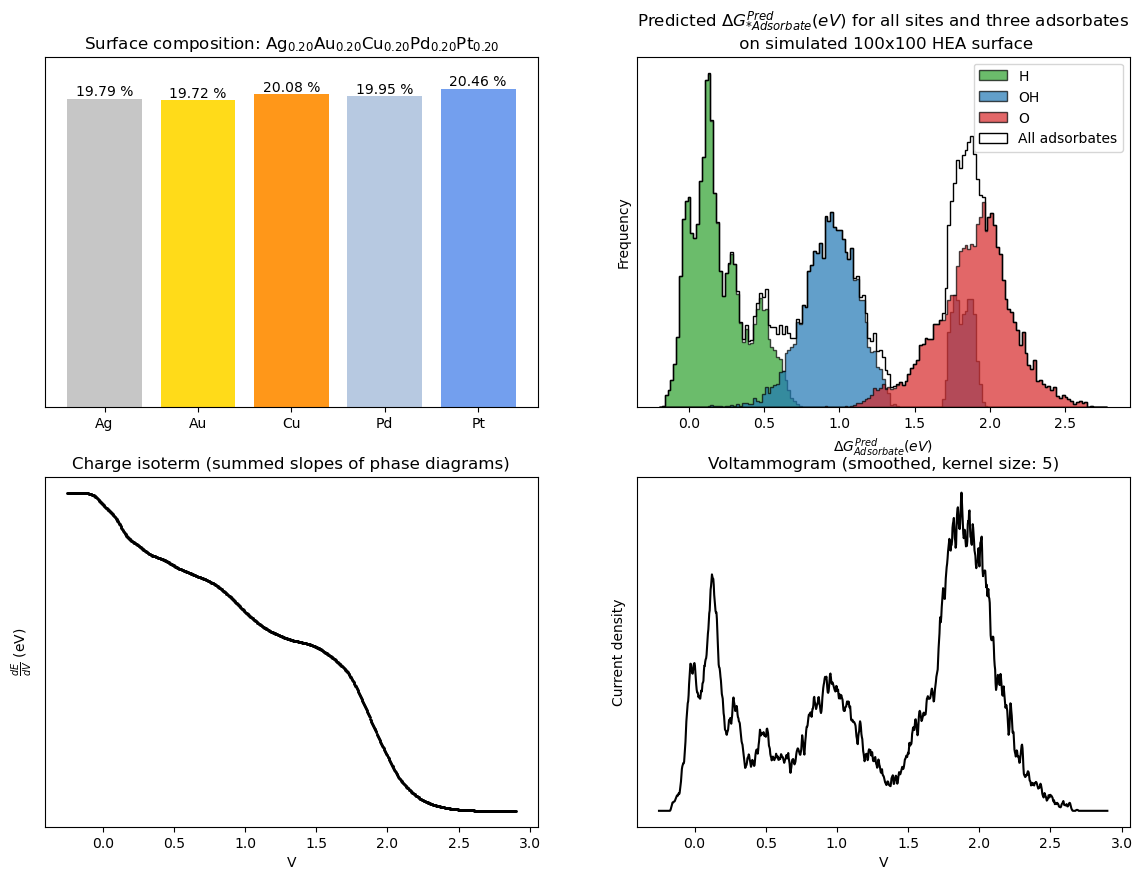

In [46]:
# Set the dimensions of the surface
dim_x, dim_y = 100, 100

# Create surface with the desired metals in the desired split
surface = create_surface(metals, dim_x, dim_y, split = "Even")

# Measure the energies and perform calculations
V_list, all_energies, H_Energies, OH_Energies, O_Energies, charge_isoterm, CV, CV_smooth = surface_to_CV(surface, on_top_site_model, hollow_site_model)

# Plot the results
super_surface_plot(metals, surface, H_Energies, OH_Energies, O_Energies, np.concatenate((H_Energies, OH_Energies, O_Energies)), V_list, charge_isoterm, CV_smooth, filename = "even_random_draw")


## Make a surface excluding one of the metals

I predicted the energy of every adsorbate on every feasible site on a 100x100 surface, resulting in 30000 energies. It took 0.46 seconds


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The filename is:  excluded_Ag
I predicted the energy of every adsorbate on every feasible site on a 100x100 surface, resulting in 30000 energies. It took 0.45 seconds


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The filename is:  excluded_Au
I predicted the energy of every adsorbate on every feasible site on a 100x100 surface, resulting in 30000 energies. It took 0.43 seconds


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The filename is:  excluded_Cu
I predicted the energy of every adsorbate on every feasible site on a 100x100 surface, resulting in 30000 energies. It took 0.48 seconds


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The filename is:  excluded_Pd
I predicted the energy of every adsorbate on every feasible site on a 100x100 surface, resulting in 30000 energies. It took 0.44 seconds


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The filename is:  excluded_Pt


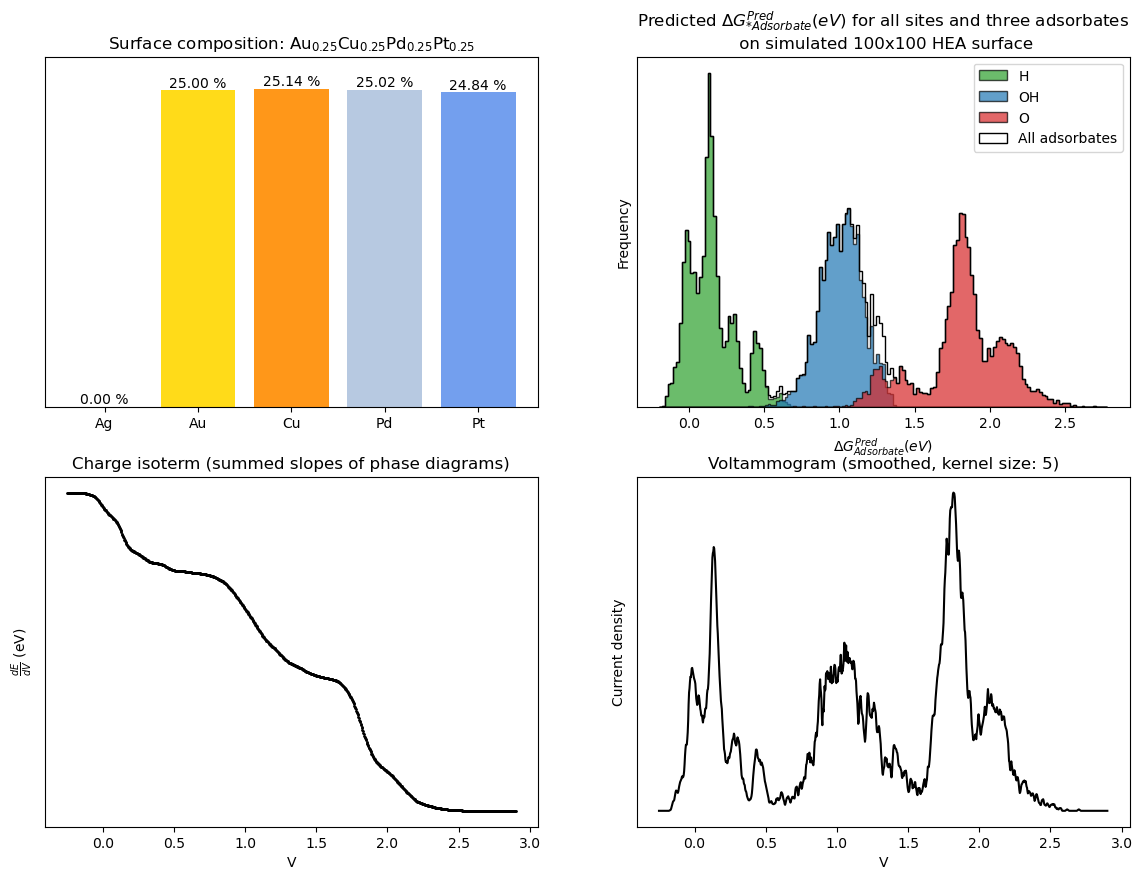

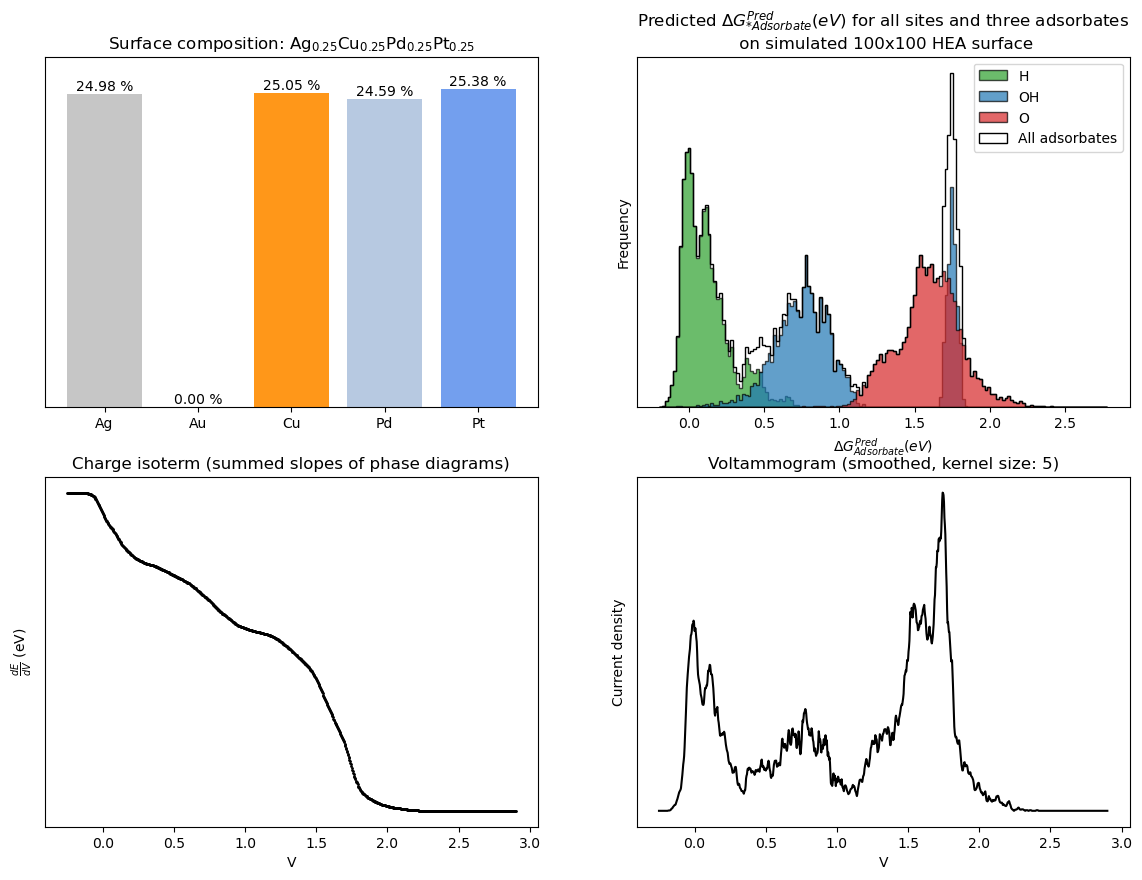

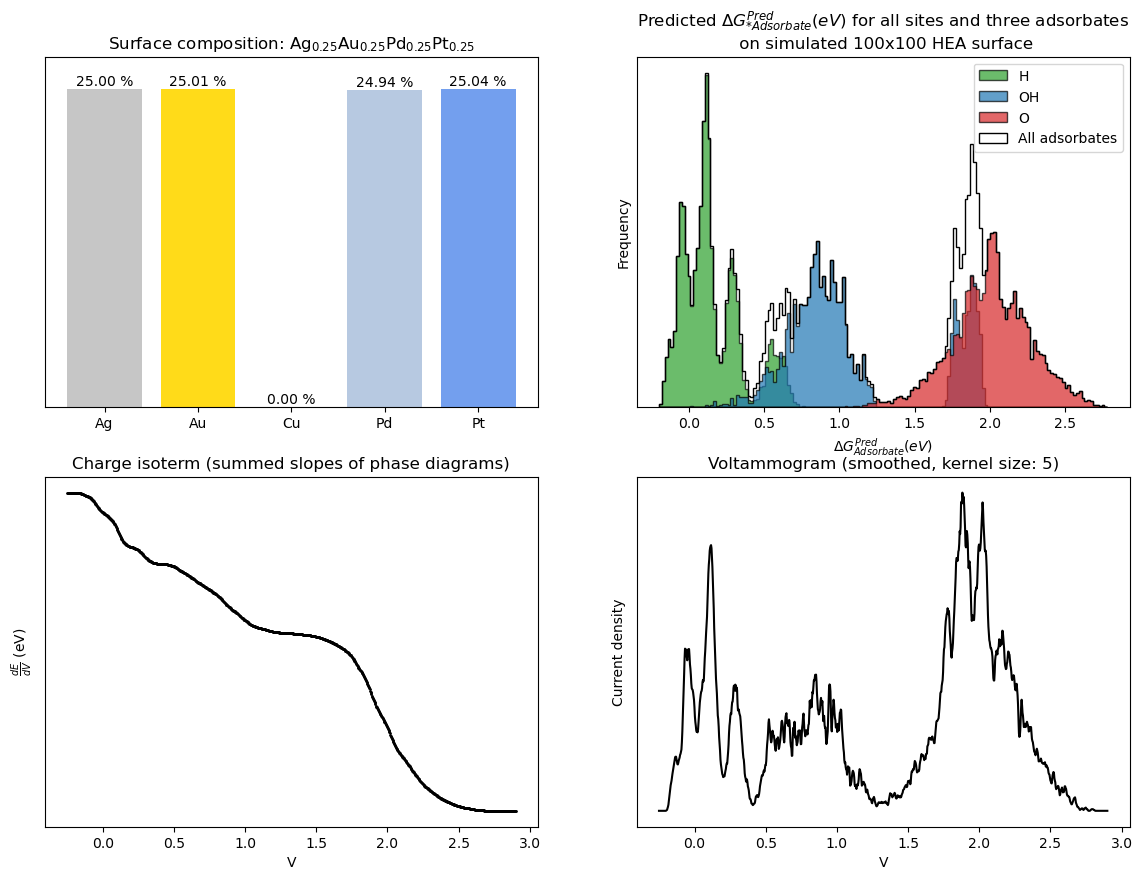

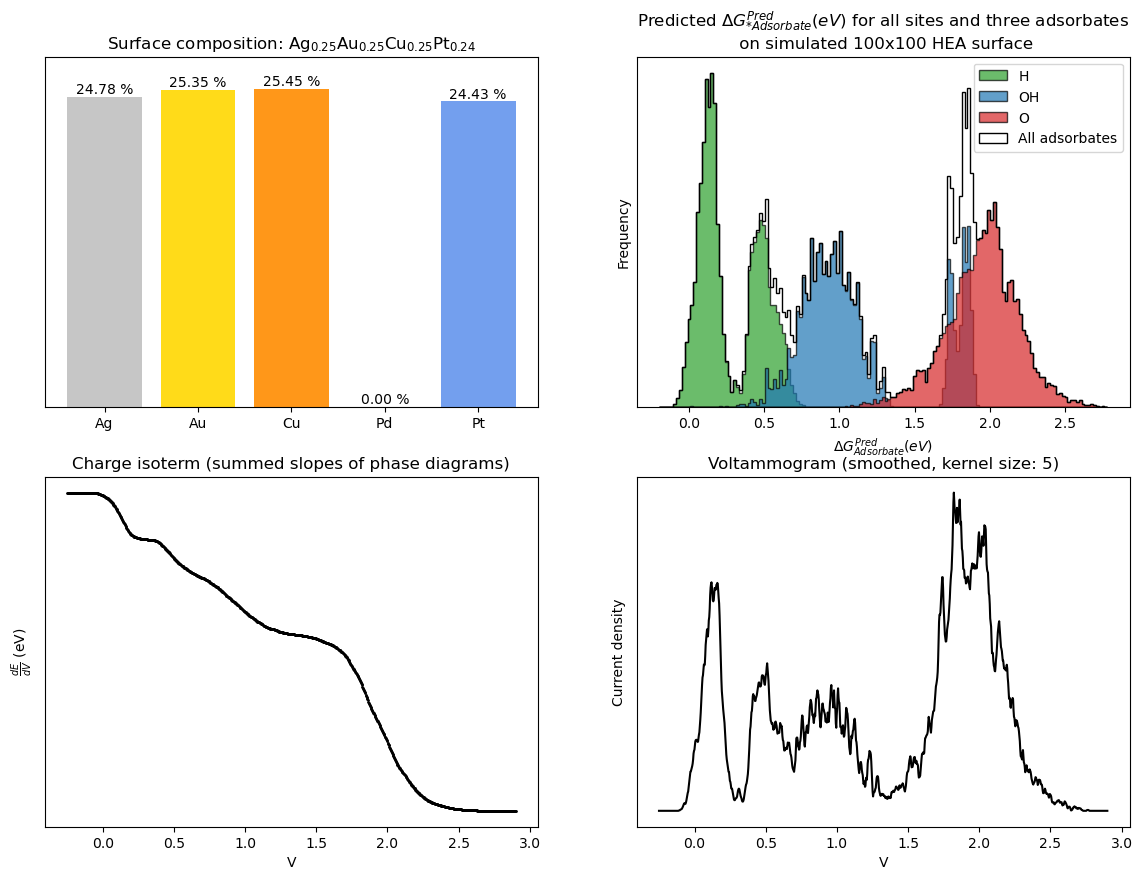

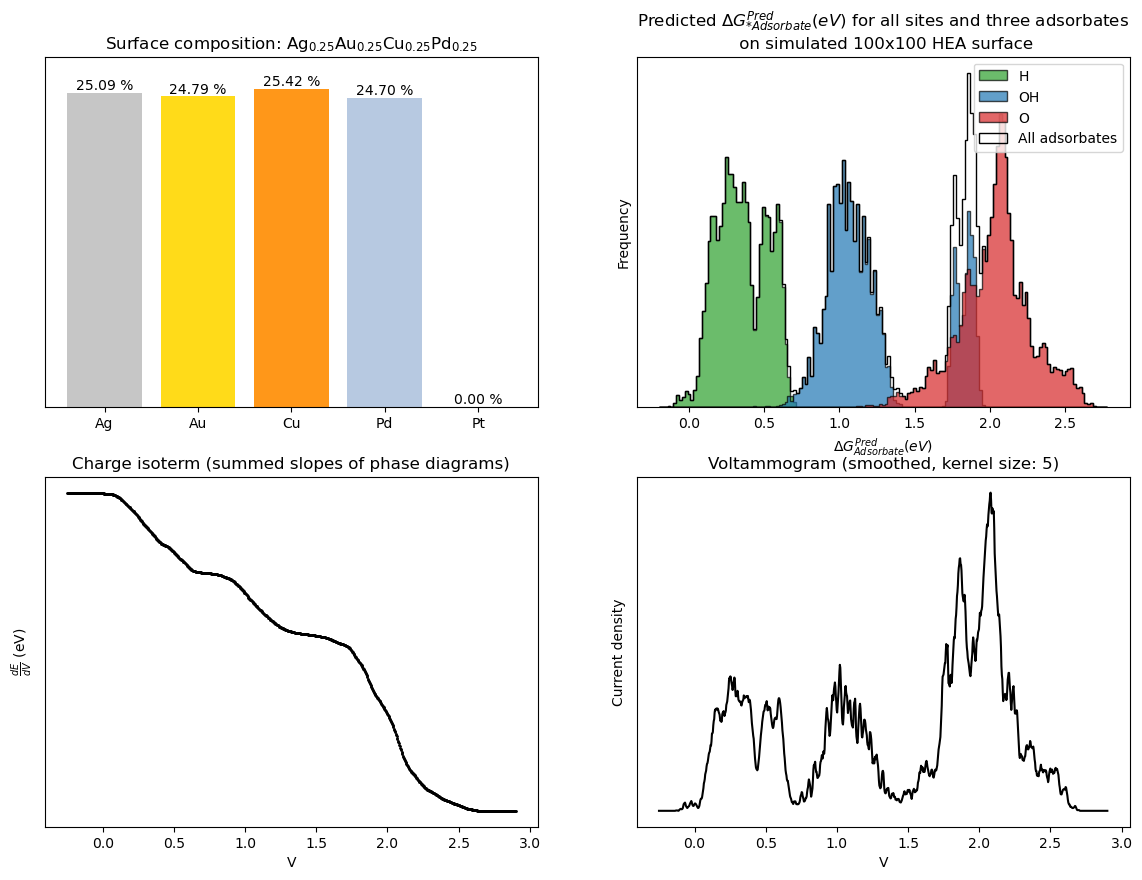

In [49]:
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']

for excluded_metal in metals:
    remaining_metals = [x for x in metals if x != excluded_metal]
    # Set the dimensions of the surface
    dim_x, dim_y = 100, 100
    
    # Create surface with the desired metals in the desired split
    surface = create_surface(remaining_metals, dim_x, dim_y, split = "Even")
    
    # Measure the energies and perform calculations
    V_list, all_energies, H_Energies, OH_Energies, O_Energies, charge_isoterm, CV, CV_smooth = surface_to_CV(surface, on_top_site_model, hollow_site_model)
    
    # Plot the results
    super_surface_plot(metals, surface, H_Energies, OH_Energies, O_Energies, np.concatenate((H_Energies, OH_Energies, O_Energies)), V_list, charge_isoterm, CV_smooth, filename = f"excluded_{excluded_metal}")


In [33]:
np.

array([0.59488606, 0.54006237, 0.49789652, ..., 0.663701  , 0.2947636 ,
       0.40020725], dtype=float32)

In [5]:
metals

['Ag', 'Au', 'Cu', 'Pd', 'Pt']

In [ ]:
np.random.choice(aa_milne_arr, 5, p=[0.5, 0.1, 0.1, 0.3])

In [307]:
def test(**filename):
    if filename:
        None
    return None

test(filename = "bingle")

In [252]:
composition.keys()

dict_keys(['Ag', 'Au', 'Cu', 'Pd', 'Pt'])

In [236]:
composition_string

'Ag$_{0.20}$Au$_{0.20}$Cu$_{0.20}$Pd$_{0.20}$Pt$_{0.20}$'

In [222]:
composition

{'Ag': 600000, 'Au': 600000, 'Cu': 600000, 'Pd': 600000, 'Pt': 600000}

In [217]:
metals

['Ag', 'Au', 'Cu', 'Pd', 'Pt']

In [216]:
surface

array([[['Pd', 'Pd', 'Pd'],
        ['Pt', 'Au', 'Pt'],
        ['Pt', 'Cu', 'Pt'],
        ...,
        ['Ag', 'Cu', 'Cu'],
        ['Pt', 'Pt', 'Ag'],
        ['Ag', 'Cu', 'Au']],

       [['Cu', 'Au', 'Pt'],
        ['Ag', 'Pt', 'Pt'],
        ['Pt', 'Au', 'Cu'],
        ...,
        ['Pt', 'Au', 'Cu'],
        ['Cu', 'Pt', 'Pd'],
        ['Cu', 'Au', 'Au']],

       [['Cu', 'Pd', 'Pt'],
        ['Pt', 'Cu', 'Pd'],
        ['Cu', 'Cu', 'Pt'],
        ...,
        ['Pd', 'Ag', 'Cu'],
        ['Ag', 'Pt', 'Ag'],
        ['Pd', 'Pt', 'Pt']],

       ...,

       [['Ag', 'Au', 'Pt'],
        ['Ag', 'Pd', 'Cu'],
        ['Pd', 'Pd', 'Pd'],
        ...,
        ['Ag', 'Ag', 'Pt'],
        ['Au', 'Ag', 'Ag'],
        ['Cu', 'Cu', 'Pd']],

       [['Pd', 'Cu', 'Pt'],
        ['Pd', 'Cu', 'Cu'],
        ['Pt', 'Pt', 'Ag'],
        ...,
        ['Pd', 'Pt', 'Pd'],
        ['Cu', 'Pt', 'Pt'],
        ['Pd', 'Cu', 'Ag']],

       [['Cu', 'Cu', 'Ag'],
        ['Cu', 'Cu', 'Ag'],
        ['Pd', '

#### Make plots of the slopes of the phase diagrams

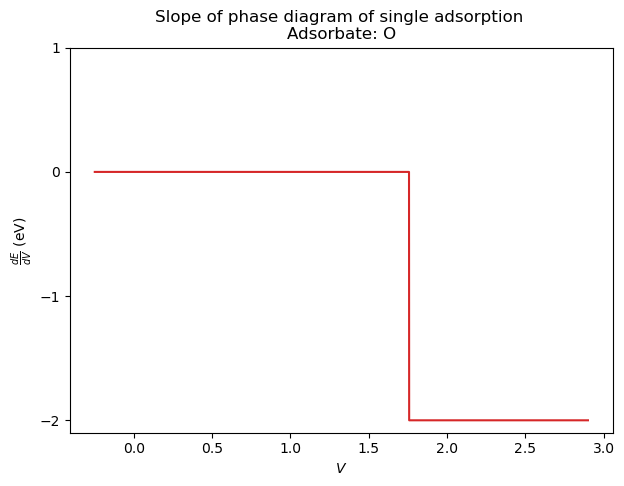

In [123]:
V_cut = O_Energies[123]
adsorbate = "O"
#diff_PD = [slopes[adsorbate] if V < V_cut else 0 for V in V_list]
diff_PD = [slopes[adsorbate] if V > V_cut else 0 for V in V_list]

fig, ax = plt.subplots(1, 1, figsize = (7, 5))
ax.plot(V_list, diff_PD, c = "tab:red")
ax.set_xlabel(r"$V$")
ax.set_ylabel(r"$\frac{dE}{dV}$ (eV)")
ax.set_title(f"Slope of phase diagram of single adsorption \nAdsorbate: O")
#ax.set_yticks([0, -2])
ax.set_yticks([1, 0, -1, -2])
#fig.savefig("../figures/CV/slope_PD_O.png", dpi = 300, bbox_inches = "tight")
fig.show()

#### The dump

In [ ]:
# Use both models on all sites
for site_x in range(100): #Looping through all on top sites
    for site_y in range(100):
        
        # Create vector for on-top site
        on_top_vec = on_top_site_vector(surface, site_x, site_y)
        
        # Create vector for hollow site / fcc site
        hollow_site_vec = hollow_site_vector(surface, site_x, site_y)
        
        #Prepare vectors for XGBoost
        on_top_vec = xgb.DMatrix(data = np.array([on_top_vec]), label = np.array([0 for n in range(len(on_top_vec))]))
        hollow_site_vec = xgb.DMatrix(data = np.array([hollow_site_vec]), label = np.array([0 for n in range(len(hollow_site_vec))]))
        
        # CALCULATE ENERGY HERE! FOR ALL REACTIONS
        on_top_energy = on_top_site_model.predict(on_top_vec)
        hollow_site_energy = hollow_site_model.predict(hollow_site_vec)
        
        # which we actually need models for. I think we only have a model for OH eller O
        # When you get here, you need to make simple models for all three adsorbates

# Plot all energies in nice colours like the parity plot

In [ ]:
on_top_vec = on_top_site_vector(surface, site_x, site_y)
print(xgb.DMatrix(data = np.array([on_top_vec]), label = np.array([0 for n in range(len(on_top_vec))])))
#on_top_site_model.predict(np.array(on_top_vec))

#### Use KDEs to smoothen the CV

In [141]:
def Gaussian(mean, error, x):
    p = 1/(np.sqrt(2*np.pi)*error)*np.exp(-(x-mean)**2/(2*error**2))
    return p

def P_KDE_gauss(x_data, x_plot_range, h):
    P_KDE_list = []
    for i in range(len(x_plot_range)):
        P = 0
        for j in range(len(x_data)):
            P += 1/len(x_data) * Gaussian(x_data[j], h, x_plot_range[i])
        P_KDE_list.append(P)
    return P_KDE_list

def Epanechnikov(mean, x):
    P = 3/4 * (1 - abs(mean-x)**2)
    if P < 0:
        P = 0
    return P

def P_KDE_epa(x_data, x_plot_range, h):
    P_KDE_list = []
    for i in range(len(x_plot_range)):
        P = 0
        for j in range(len(x_data)):
            P += 1/len(x_data) * Epanechnikov(x_data[j], x_plot_range[i])
        P_KDE_list.append(P)
    return P_KDE_list

KDE_CV = P_KDE_epa(diff_sum_diff_pd, V_list, 0.005)

fig, ax = plt.subplots(1, 1, figsize = (7, 5))

ax.plot(V_list, KDE_CV, c = "black") #, s = 5
ax.set_yticks([])
ax.set_ylabel("Current density")
ax.set_xlabel("V")

#fig.savefig("../figures/CV/CV_smooth.png", dpi = 300, bbox_inches = "tight")
fig.show()

# I think I have to run this through a spline to get a clean line